<img src="./assets/resnet50_cover.png" alt="cover" align=center/>

# 图像分类

<img src="./assets/resnet50_image_classification.png" width="800" alt="image-classification" align=center/>

> 图片来源：https://en.wikipedia.org/wiki/Yellow-headed_blackbird

图像分类是最基础的计算机视觉应用，属于有监督学习类别，如给定一张图像(猫、狗、飞机、汽车等等)，判断图像所属的类别。

本章将介绍使用ResNet50网络对CIFAR-10数据集进行分类。

<img src="./assets/resnet50_deep_learning_training.png" width="800" alt="deep-learning-training" align=center/>

- 正向计算结果（logits）
- 计算结果（logits）与正确标签（targets）的误差
- 反向传播获取梯度
- 更新梯度到网络权重

# 深度学习全流程

- <font color=#1E77CC>数据预处理： 将图像、文本等数据处理为可以计算的Tensor</font>
- 神经网络构建： 使用框架API， 搭建神经网络
- 模型训练： 定义模型**训练逻辑**， 遍历**训练集**进行训练
- 模型评估： 使用训练好的模型， 在**测试集**评估效果
- 模型推理： 将训练好的模型部署， 输入新数据获得预测结果

# 数据预处理

<img src="./assets/resnet50_data_pipeline.png" align=center>

## 数据集下载

本次我们使用CIFAR-10数据集。它共有60000张32*32的彩色图像，分为10个类别，每类有6000张图，数据集一共有50000张训练图片和10000张评估图片。

<img src="./assets/resnet50_cifar10.png" width="500" alt="image-classification" align=center/>

首先，如下示例使用`download`接口下载并解压，目前仅支持解析二进制版本的CIFAR-10文件（CIFAR-10 binary version）。

In [30]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

download(url, "./datasets-cifar10-bin", kind="tar.gz")

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


'./datasets-cifar10-bin'

## 数据集预处理相关操作

使用`mindspore.dataset.Cifar10Dataset`接口来加载数据集，并进行相关图像增强操作。

In [31]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin"  # 数据集根目录
batch_size = 256  # 批量大小
image_size = 32  # 训练图像空间大小
workers = 4  # 并行线程个数
num_classes = 10  # 分类数量

In [32]:
def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):
    
    # 数据集加载与操作
    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)

    # 数据集样本增强
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set

In [33]:
# 获取处理后的训练与测试数据集

dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

print(f"size of training dataset = {step_size_train}")
print(f"size of validation dataset = {step_size_val}")

# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

size of training dataset = 196
size of validation dataset = 40


对CIFAR-10训练数据集进行可视化。

Image shape: (256, 3, 32, 32), Label shape: (256,)
Labels: [9 7 2 1 0 8]


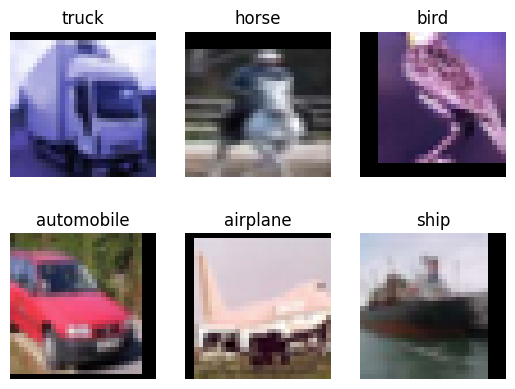

In [34]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label shape: {labels.shape}")

# 训练数据集中，前六张图片所对应的标签
print(f"Labels: {labels[:6]}")

classes = []

with open(data_dir + "/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line:
            classes.append(line)

# 训练数据集的前六张图片
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

# 深度学习全流程

- 数据预处理： 将图像、文本等数据处理为**可以计算的Tensor**
- <font color=#1E77CC>神经网络构建： 使用框架API， 搭建神经网络<font>
- 模型训练： 定义模型**训练逻辑**， 遍历**训练集**进行训练
- 模型评估： 使用训练好的模型， 在**测试集**评估效果
- 模型推理： 将训练好的模型部署， 输入新数据获得预测结果

# 神经网络构建

- \[ what | 构建什么 \]：ReNet网络
- \[ how | 怎样构建 \]：面向对象式编程

## ResNet网络

ResNet网络提出了 **残差网络结构(Residual Network)** 来减轻**退化问题**。

- **退化问题**：随着网络层数变深，网络表现反而不如浅层网络

<img src="./assets/resnet50_net_degradation.png" alt="net-degradation" align=center/>

- **残差网络结构**：$F(x) \rightarrow F(x)+x$

<img src="./assets/resnet50_resnet.png" align=center/>

ResNet50就是由这样多个残差块堆叠而成的。

## 面向对象编程（OOP）

MindSpore2.0采取OOP+FP混合式编程，其中在网络构建中使用了面向对象式编程（OOP）。

$$\text{构造类} \rightarrow \text{实例化对象} \rightarrow \text{对象调用}$$

<img src="./assets/resnet50_oop.png" width="800" align=center/>

- 继承`nn.Cell`构造网络结构
- 在`__init__`只能实例化神经网络
- 在`construct`方法中书写正向计算逻辑

## 构建残差块 —— Building Block

<img src="./assets/resnet50_building_block.png" width="500" align=center/>

如下代码定义`ResidualBlockBase`类实现Building Block结构。

In [35]:
from typing import Type, Union, List, Optional
import mindspore.nn as nn
from mindspore.common.initializer import Normal

# 初始化卷积层与BatchNorm的参数
weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class ResidualBlockBase(nn.Cell):
    expansion: int = 1  # 最后一个卷积核数量与第一个卷积核数量相等

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, norm: Optional[nn.Cell] = None,
                 down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlockBase, self).__init__()
        if not norm:
            self.norm = nn.BatchNorm2d(out_channel)
        else:
            self.norm = norm

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.conv2 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=3, weight_init=weight_init)
        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):
        """ResidualBlockBase construct."""
        identity = x  # shortcuts分支

        out = self.conv1(x)  # 主分支第一层：3*3卷积层
        out = self.norm(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)
        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

## 构建残差块 —— BottleNeck

在输入相同的情况下Bottleneck结构相对Building Block结构的参数数量更少，更适合层数较深的网络，ResNet50使用的残差结构就是Bottleneck。

<img src="./assets/resnet50_bottleneck.png" width="800" align=center/>

如下代码定义`ResidualBlock`类实现Bottleneck结构。

In [36]:
class ResidualBlock(nn.Cell):
    expansion = 4  # 最后一个卷积核的数量是第一个卷积核数量的4倍

    def __init__(self, in_channel: int, out_channel: int,
                 stride: int = 1, down_sample: Optional[nn.Cell] = None) -> None:
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel,
                               kernel_size=1, weight_init=weight_init)
        self.norm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel,
                               kernel_size=3, stride=stride,
                               weight_init=weight_init)
        self.norm2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, out_channel * self.expansion,
                               kernel_size=1, weight_init=weight_init)
        self.norm3 = nn.BatchNorm2d(out_channel * self.expansion)

        self.relu = nn.ReLU()
        self.down_sample = down_sample

    def construct(self, x):

        identity = x  # shortscuts分支

        out = self.conv1(x)  # 主分支第一层：1*1卷积层
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)  # 主分支第二层：3*3卷积层
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv3(out)  # 主分支第三层：1*1卷积层
        out = self.norm3(out)

        if self.down_sample is not None:
            identity = self.down_sample(x)

        out += identity  # 输出为主分支与shortcuts之和
        out = self.relu(out)

        return out

## 堆叠残差块

![resnet-layer](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.0/tutorials/application/source_zh_cn/cv/images/resnet_2.png)

如下示例定义`make_layer`实现残差块的构建，其参数如下所示:

+ `last_out_channel`：上一个残差网络输出的通道数。
+ `block`：残差网络的类别，分别为`ResidualBlockBase`和`ResidualBlock`。
+ `channel`：残差网络输入的通道数。
+ `block_nums`：残差网络块堆叠的个数。
+ `stride`：卷积移动的步幅。

In [37]:
def make_layer(last_out_channel, block: Type[Union[ResidualBlockBase, ResidualBlock]],
               channel: int, block_nums: int, stride: int = 1):
    down_sample = None  # shortcuts分支

    if stride != 1 or last_out_channel != channel * block.expansion:

        down_sample = nn.SequentialCell([
            nn.Conv2d(last_out_channel, channel * block.expansion,
                      kernel_size=1, stride=stride, weight_init=weight_init),
            nn.BatchNorm2d(channel * block.expansion, gamma_init=gamma_init)
        ])

    layers = []
    layers.append(block(last_out_channel, channel, stride=stride, down_sample=down_sample))

    in_channel = channel * block.expansion
    # 堆叠残差网络
    for _ in range(1, block_nums):

        layers.append(block(in_channel, channel))

    return nn.SequentialCell(layers)

主分支与shortcuts输出的特征矩阵相加时，需要保证主分支与shortcuts输出的特征矩阵shape相同。

如果主分支与shortcuts输出的特征矩阵shape不相同，如输出channel是输入channel的一倍时，shortcuts上需要使用数量与输出channel相等，大小为$1\times1$的卷积核进行卷积操作；若输出的图像较输入图像缩小一倍，则要设置shortcuts中卷积操作中的`stride`为2，主分支第二层卷积操作的`stride`也需设置为2。

<img src="./assets/resnet50_downsample.png" width="800" align=center/>

## 构建ResNet50网络

ResNet50网络共有5个卷积结构，一个平均池化层，一个全连接层，以CIFAR-10数据集为例：

+ **conv1**：输入图片大小为$32\times32$，输入channel为3。首先经过一个卷积核数量为64，卷积核大小为$7\times7$，stride为2的卷积层；然后通过一个Batch Normalization层；最后通过Reul激活函数。该层输出feature map大小为$16\times16$，输出channel为64。
+ **conv2_x**：输入feature map大小为$16\times16$，输入channel为64。首先经过一个卷积核大小为$3\times3$，stride为2的最大下采样池化操作；然后堆叠3个$[1\times1，64；3\times3，64；1\times1，256]$结构的Bottleneck。该层输出feature map大小为$8\times8$，输出channel为256。
+ **conv3_x**：输入feature map大小为$8\times8$，输入channel为256。该层堆叠4个[1×1，128；3×3，128；1×1，512]结构的Bottleneck。该层输出feature map大小为$4\times4$，输出channel为512。
+ **conv4_x**：输入feature map大小为$4\times4$，输入channel为512。该层堆叠6个[1×1，256；3×3，256；1×1，1024]结构的Bottleneck。该层输出feature map大小为$2\times2$，输出channel为1024。
+ **conv5_x**：输入feature map大小为$2\times2$，输入channel为1024。该层堆叠3个[1×1，512；3×3，512；1×1，2048]结构的Bottleneck。该层输出feature map大小为$1\times1$，输出channel为2048。
+ **average pool & fc**：输入channel为2048，输出channel为分类的类别数。

如下示例代码实现ResNet50模型的构建，通过用调函数`resnet50`即可构建ResNet50模型，函数`resnet50`参数如下：

+ `num_classes`：分类的类别数，默认类别数为1000。
+ `pretrained`：下载对应的训练模型，并加载预训练模型中的参数到网络中。

In [38]:
class ResNet(nn.Cell):
    def __init__(self, block: Type[Union[ResidualBlockBase, ResidualBlock]],
                 layer_nums: List[int], num_classes: int, input_channel: int) -> None:
        super(ResNet, self).__init__()

        self.relu = nn.ReLU()
        # 第一个卷积层，输入channel为3（彩色图像），输出channel为64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, weight_init=weight_init)
        self.norm = nn.BatchNorm2d(64)
        # 最大池化层，缩小图片的尺寸
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        # 各个残差网络结构块定义
        self.layer1 = make_layer(64, block, 64, layer_nums[0])
        self.layer2 = make_layer(64 * block.expansion, block, 128, layer_nums[1], stride=2)
        self.layer3 = make_layer(128 * block.expansion, block, 256, layer_nums[2], stride=2)
        self.layer4 = make_layer(256 * block.expansion, block, 512, layer_nums[3], stride=2)
        # 平均池化层
        self.avg_pool = nn.AvgPool2d()
        # flattern层
        self.flatten = nn.Flatten()
        # 全连接层
        self.fc = nn.Dense(in_channels=input_channel, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

在本任务中，我们并未从头训练一个全新的模型；而是通过`load_checkpoint`、`load_param_intp_net`加载一个训练好的模型参数，并根据实际任务进行微调（fine-tune）。

In [39]:
from mindspore import load_checkpoint, load_param_into_net

def _resnet(model_url: str, block: Type[Union[ResidualBlockBase, ResidualBlock]],
            layers: List[int], num_classes: int, pretrained: bool, pretrained_ckpt: str,
            input_channel: int):
    model = ResNet(block, layers, num_classes, input_channel)

    if pretrained:
        # 加载预训练模型
        download(url=model_url, path=pretrained_ckpt)
        param_dict = load_checkpoint(pretrained_ckpt)
        load_param_into_net(model, param_dict)

    return model


def resnet50(num_classes: int = 1000, pretrained: bool = False):
    "ResNet50模型"
    resnet50_url = "https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/models/application/resnet50_224_new.ckpt"
    resnet50_ckpt = "./LoadPretrainedModel/resnet50_224_new.ckpt"
    return _resnet(resnet50_url, ResidualBlock, [3, 4, 6, 3], num_classes,
                   pretrained, resnet50_ckpt, 2048)

## 网络实例化

调用`resnet50`构造ResNet50模型，并设置`pretrained`参数为True，将会自动下载ResNet50预训练模型，并加载预训练模型中的参数到网络中。

由于预训练模型全连接层（fc）的输出大小（对应参数`num_classes`）为1000， 为了成功加载预训练权重，我们将模型的全连接输出大小设置为默认的1000。CIFAR10数据集共有10个分类，在使用该数据集进行训练时，需要将加载好预训练权重的模型全连接层输出大小重置为10。

In [40]:
# ResNet50网络实例化
network = resnet50(pretrained=True)

# 全连接层输入层的大小
in_channel = network.fc.in_channels
fc = nn.Dense(in_channels=in_channel, out_channels=10)
# 重置全连接层
network.fc = fc

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


# 深度学习全流程

- 数据预处理： 将图像、文本等数据处理为**可以计算的Tensor**
- 神经网络构建： 使用框架API， 搭建神经网络
- <font color=#1E77CC>模型训练： 定义模型训练逻辑， 遍历训练集进行训练<font>
- <font color=#1E77CC>模型评估： 使用训练好的模型， 在测试集评估效果<font>
- 模型推理： 将训练好的模型部署， 输入新数据获得预测结果

# 模型训练

## Parameter and Hyper-parameter

- **模型参数（parameter）**：神经网络需要从数据中学习和估计得到，需要训练的参数矩阵或向量，在模型定义时采用随机初始化，通常是nn层内的weight/bias/gamma/beta等属性。
- **超参数（Hyper-Parameter）**：需要人为设定的调优参数。如hidden size，learning rate，number of layers，epochs/steps

In [41]:
# 模型参数
for i, param in enumerate(network.get_parameters()):
    print(param)
    if i == 9:
        break

Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True)
Parameter (name=norm.moving_mean, shape=(64,), dtype=Float32, requires_grad=False)
Parameter (name=norm.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)
Parameter (name=norm.gamma, shape=(64,), dtype=Float32, requires_grad=True)
Parameter (name=norm.beta, shape=(64,), dtype=Float32, requires_grad=True)
Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True)
Parameter (name=layer1.0.norm1.moving_mean, shape=(64,), dtype=Float32, requires_grad=False)
Parameter (name=layer1.0.norm1.moving_variance, shape=(64,), dtype=Float32, requires_grad=False)
Parameter (name=layer1.0.norm1.gamma, shape=(64,), dtype=Float32, requires_grad=True)
Parameter (name=layer1.0.norm1.beta, shape=(64,), dtype=Float32, requires_grad=True)


In [42]:
# 超参数
num_epochs = 5  # 训练epochs数
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)  # 学习率

## 定义优化器和损失函数

- **损失函数（loss function）**：定义模型计算结果（logits）与正确标签（targets）之间误差的计算方式

根据模型和任务场景，选择合适的损失函数，如本案例属于多分类问题，适合使用交叉熵损失（CrossEntropyLoss）。其他损失函数接口可参考MindSpore官网API文档`mindspore.nn`中的[损失函数](https://www.mindspore.cn/docs/zh-CN/r2.0.0-alpha/api_python/mindspore.nn.html#%E6%8D%9F%E5%A4%B1%E5%87%BD%E6%95%B0)。

In [43]:
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

- **模型优化（optimization）**：在每个训练步骤中调整模型参数以减少模型误差的过程。

<img src="./assets/resnet50_optimization.png" width="800" align=center/>

MindSpore提供多种优化算法的实现，称之为**优化器（Optimizer）**。优化器内部定义了模型的参数优化过程（即梯度如何更新至模型参数），所有优化逻辑都封装在优化器对象中。在这里，我们使用Momentum优化器。

我们通过`model.trainable_params()`方法获得模型的可训练参数，并传入学习率超参来初始化优化器。

In [44]:
opt = nn.Momentum(params=network.trainable_params(), learning_rate=lr, momentum=0.9)

for i, param in enumerate(network.trainable_params()):
    print(param)
    if i == 4:
        break

Parameter (name=conv1.weight, shape=(64, 3, 7, 7), dtype=Float32, requires_grad=True)
Parameter (name=norm.gamma, shape=(64,), dtype=Float32, requires_grad=True)
Parameter (name=norm.beta, shape=(64,), dtype=Float32, requires_grad=True)
Parameter (name=layer1.0.conv1.weight, shape=(64, 64, 1, 1), dtype=Float32, requires_grad=True)
Parameter (name=layer1.0.norm1.gamma, shape=(64,), dtype=Float32, requires_grad=True)


## 训练逻辑

### 函数式编程（FP）

MindSpore2.0采用OOP+FP混合编程，在模型训练部分使用函数式编程（FP）。

$$\text{构造函数}\rightarrow \text{函数变换} \rightarrow \text{函数调用}$$

<img src="./assets/resnet50_fp.png" width="800" align=center/>

1. Network+Loss直接构造正向函数
2. 函数变换，获得梯度计算（反向传播）函数
3. 构造训练过程函数
4. 调用函数进行训练

In [45]:
def forward_fn(inputs, targets):
    """正向计算loss"""
    logits = network(inputs)
    loss = loss_fn(logits, targets)
    return loss


# 梯度计算函数
grad_fn = ms.value_and_grad(forward_fn, None, opt.parameters)


def train_step(inputs, targets):
    # 反向传播，获得梯度
    loss, grads = grad_fn(inputs, targets)
    # 权重更新
    opt(grads)
    return loss

## 模型训练

数据集遍历迭代，一次完整的数据集遍历成为一个epoch。我们逐个epoch打印训练的损失值和评估精度，并通过`save_checkpoint`保存评估精度最高的ckpt文件（resnet50-best.ckpt）到当前路径的./BestCheckPoint下。

在训练中，模型会以最小化损失为目标更新模型权重，故模型状态需设置为训练`model.set_train(True)`。

在评估中，仅需正向计算loss，无需更新模型参数,故模型状态需设置为训练`model.set_train(False)`。

In [46]:
import os

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/resnet50-best.ckpt"

if not os.path.exists(best_ckpt_dir):
    os.mkdir(best_ckpt_dir)

In [47]:
import mindspore.ops as ops


def train(data_loader, epoch):
    """模型训练"""
    losses = []
    network.set_train(True)
    
    # 遍历数据集
    for i, (images, labels) in enumerate(data_loader):
        loss = train_step(images, labels) # 一个step的训练
        if i % 100 == 0 or i == step_size_train - 1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]' %
                  (epoch + 1, num_epochs, i + 1, step_size_train, loss))
        losses.append(loss)

    return sum(losses) / len(losses)


def evaluate(data_loader):
    """模型验证"""
    network.set_train(False)

    correct_num = 0.0  # 预测正确个数
    total_num = 0.0  # 预测总数

    for images, labels in data_loader:
        logits = network(images)
        pred = logits.argmax(axis=1)  # 预测结果
        correct = ops.equal(pred, labels).reshape((-1, ))
        correct_num += correct.sum().asnumpy()
        total_num += correct.shape[0]

    acc = correct_num / total_num  # =准确率

    return acc

In [ ]:
import time
# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    
    train_start = time.time()
    curr_loss = train(data_loader_train, epoch)
    curr_acc = evaluate(data_loader_val)
    train_end = time.time()

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f], Training Time: [%5.1f]s" % (
        epoch+1, num_epochs, curr_loss, curr_acc, train_end - train_start
    ))
    print("-" * 50)

    # 保存当前预测准确率最高的模型
    if curr_acc > best_acc:
        best_acc = curr_acc
        ms.save_checkpoint(network, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)

# 深度学习全流程

- 数据预处理： 将图像、文本等数据处理为**可以计算的Tensor**
- 神经网络构建： 使用框架API， 搭建神经网络
- 模型训练： 定义模型**训练逻辑**， 遍历**训练集**进行训练
- 模型评估： 使用训练好的模型， 在**测试集**评估效果
- <font color=#1E77CC>模型推理： 将训练好的模型部署， 输入新数据获得预测结果<font>

## 可视化模型推理

定义`visualize_model`函数，使用上述验证精度最高的模型对CIFAR-10测试数据集进行预测，并将预测结果可视化。若预测字体颜色为蓝色表示为预测正确，预测字体颜色为红色则表示预测错误。

In [ ]:
import matplotlib.pyplot as plt


def visualize_model(best_ckpt_path, dataset_val):
    num_class = 10  # 对狼和狗图像进行二分类
    net = resnet50(num_class)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    # 预测图像类别
    output = net(data['image'])
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = []

    with open(data_dir + "/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line:
                classes.append(line)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)

# 计算图

- **动态图： 其核心特点是计算图的构建和计算同时发生（Define by run）**
    - **原理**： 类似Python解释器，在计算图中定义一个Tensor时，其值就已经被计算且确定了。
    - **优点**： Pythonic语法，在调试模型时较为方便，能够实时得到中间结果的值。
    - **缺点**： 由于所有节点都需要被保存，导致难以对整个计算图进行优化。

- **静态图：将计算图的构建和实际计算分开（Define and run）**
    - **原理**： 在构建阶段，根据完整的计算流程对原始的计算图进行优化和调整， 编译得到更省内存和计算量更少的计算图。编译之后图的结构不再改变，所以称之为 “静态图” 。 在计算阶段，根据输入数据执行编译好的计算图得到计算结果。
    - **优点**： 静态图相比起动态图，对全局的信息掌握更丰富，可做的优化也会更多。
    - **缺点**： 中间过程对于用户来说是个黑盒，无法像动态图一样实时拿到中间计算结果。

In [60]:
print(f"current mode = {ms.get_context('mode')}")
print(f"current mode is pynative mode: {ms.get_context('mode') == ms.PYNATIVE_MODE}")

current mode = 1
current mode is pynative mode: True


# 即时编译（Just In Time, JIT）

`mindspore.jit`修饰器：
- 一行代码切换动静态图
- 即时编译，被修饰的函数转换为整图

<img src="./assets/resnet50_jit.png" width="500" align=center/>